## Peliminary Results

#### importing data

In [1]:
import pandas as pd
import numpy as np 
import requests,json, pickle, glob
from datetime import datetime

In [2]:
# write a function that receive the range of dates
# and get the data from the folders
# and append to the dataframe

# oragon = pd.read_excel('https://query.data.world/s/tnmiycnhx4mu4777vps4nphqm4qeoh')
# oragon

# PATH = r'C:/Users/ktadesse/Google Drive/research/VACCINE/Research Direction/Napa Valley/2016/'

# df_rain = pd.read_csv(PATH + 'rainfall.csv', names=['dates', 'inches']) #, index_col='dates')
# df_stages = pd.read_csv(PATH+'stages.csv', names=['dates', 'types'])

# # resetting the date as an index
# rain = df_rain.set_index('dates')
# stages = df_stages.set_index('dates')

# # convering the date to a date datatype
# rain.index = pd.to_datetime(rain.index)
# stages.index = pd.to_datetime(stages.index)

path = r'C:/Users/ktadesse/Google Drive/research/VACCINE/Research Direction/Napa Valley/'
filenames = glob.glob(path +"*/rainfall.csv")

# big_fame = pd.concat([pd.read_csv(f, names=['dates', 'inches']) for f in glob.glob(path +"*/rainfall.csv")],
#                     ignore_index=True, sort=Ture)
df_rain = pd.concat([pd.read_csv(f, names=['dates','inches']) for f in glob.glob(path +"*/rainfall.csv")])
df_stages = pd.concat([pd.read_csv(f, names=['dates','types']) for f in glob.glob(path +"*/stages.csv")])

# resetting the date as an index
rain = df_rain.set_index('dates')
stages = df_stages.set_index('dates')

# convering the date to a date datatype
rain.index = pd.to_datetime(rain.index)
stages.index = pd.to_datetime(stages.index)


In [3]:
API_KEY = 'fc26f8f4-3474-4ffa-b60e-2b39b66a46a0' # '61a06bdc-a5b5-4229-9f61-b91bdff8ca63'  
dataItems_list = ['day-air-tmp-avg','day-air-tmp-max','day-air-tmp-min','day-dew-pnt','day-eto','day-asce-eto','day-asce-etr','day-precip','day-sol-rad-avg','day-wind-spd-avg']
dataItems = ','.join(dataItems_list)
BASE_URL = 'http://et.water.ca.gov/api/data?appKey={}&targets={}&startDate={}&endDate={}&dataItems={}&prioritizeSCS=N'

def extract_weather_data(zipcode, start_date, end_date):
    records = []
    request= BASE_URL.format(API_KEY,zipcode,start_date, end_date, dataItems)
    response = requests.get(request)
    data =response.json()
    if response.status_code == 200:
#         data = response.json()
        dates, hours, frames, Eto_values, col_names, DayPrecip, DayAirTmpMin, DayAirTmpMax, DayEto, DayAirTmpAvg, DaySolRadAvg, DayWindSpdAvg = ([] for i in range(12))
        for i, day in enumerate(data['Data']['Providers'][0]['Records']):
            dates.append(day['Date'])
            Eto_values.append(day['DayAsceEto']['Value'])
            DayPrecip.append(day['DayPrecip']['Value'])
            DayAirTmpMin.append(day['DayAirTmpMin']['Value'])
            DayAirTmpMax.append(day['DayAirTmpMax']['Value'])
            DayEto.append(day['DayEto']['Value'])
            DayAirTmpAvg.append(day['DayAirTmpAvg']['Value'])
            DaySolRadAvg.append(day['DaySolRadAvg']['Value'])
            DayWindSpdAvg.append(day['DayWindSpdAvg']['Value'])
            # hours.append(int(day.get('Hour', '0000'))/100)
            reqdata = {'DayPrecip': DayPrecip, 'DayAirTmpMin': DayAirTmpMin, 'DayAirTmpMax': DayAirTmpMax,
                       'DayEto': DayEto, 'DayAirTmpAvg': DayAirTmpAvg, 'DayAirTmpAvg': DayAirTmpAvg,
                       'DaySolRadAvg': DaySolRadAvg, 'DayWindSpdAvg': DayWindSpdAvg, 'Eto_values': Eto_values}
            df = pd.DataFrame(reqdata, dtype=float)
            df.index = dates
        df.index = pd.to_datetime(df.index) 
        df = df.dropna()
    else:
        return response   
    return df

In [4]:
def weather_mulit_years(start, end):
    years = pd.date_range(start, end, freq='Y')
    start = start
    df_yrs = []
    for indx, i in enumerate(years.date):
        end = years.date[indx]
        df = extract_weather_data('94581',start,end)
        df_yrs.append(df)
        start = end
    dataset = pd.concat([*df_yrs], axis=0)
    dataset = dataset.drop_duplicates()
    
    return dataset

In [5]:
# df = weather_mulit_years('2010-01-01','2017-12-31')

# df[df.index.duplicated(keep=False)]

# df.iloc['2011-01-09']

In [6]:
# We need to take one type and range of dates
# make a dataframe
# make index date range
# return the dataset of a given datatype
def make_dataset(kind, start, end):
    df = weather_mulit_years(start, end)
    

    duration = pd.date_range(start, end, freq='D')
    
    dataset = pd.DataFrame(columns=['minTemp', 'maxTemp', 'Eto_values','DayPrecip','WindSpd','DaySolRad','rain','type','stage'])
    
    start = np.nan
    
    #going through the 4 types of wine (Sauvignon Blanc, Chardonnay, Merlot, and Cabernet Sauvignon)
#     for kind in set(df_stages['types']):

    DATA = {'Start': stages[stages['types'] == kind].index.tolist(),
           'Stages':[(i%4) for i in range(stages[stages['types']==1].shape[0])] #['Bud', 'Bloom','Veraison', 'Harvest']
           }
    dfs = pd.DataFrame(DATA).set_index('Start')

#         going through each date
    for i in duration.date:
        if i in df.index:
            entry = pd.DataFrame({'minTemp': df.loc[i,'DayAirTmpMin'],
                                 'maxTemp': df.loc[i,'DayAirTmpMax'],
                                  'Eto_values':df.loc[i,'Eto_values'],
                                  'DayPrecip': df.loc[i,'DayPrecip'],
                                  'WindSpd': df.loc[i,'DayWindSpdAvg'],
                                  'DaySolRad': df.loc[i,'DaySolRadAvg']
                                 }, index=[i])

        # adding rain 
        if(rain.loc[rain.index.month == i.month]['inches'].empty == True):
            entry['rain'] = 0.00
        else:
            entry['rain'] = rain.loc[rain.index.month == i.month]['inches'][0]

        # adding type
        entry['type'] = kind

        # adding stage
        if(i in dfs.index):
            entry['stage'] = dfs.loc[i][0]
            start = dfs.loc[i][0]           
        else:
            # check for the Harevest day
            # if Harvest day has been recorded
            # no need to record the other dates
            if(start == np.int64(3)):
                start = np.nan
                entry['stage'] = start
            else:
                entry['stage'] = start

        dataset = dataset.append(entry, sort=False)
        
    return dataset

In [7]:
# for i in range(stages[stages['types']==1].shape[0]):
#     print((i%4)+1)


# use = make_dataset(1,'2010-01-01', '2017-12-31')

# use

#### pickleing 


In [8]:
def save_data(data, name):
    path = "../data/"
    with open(path+"pkl/"+name+".pkl", 'wb') as f:
        pickle.dump(data, f)
        
    data.to_csv(path+'csv/'+name+'.csv',sep=",")
    

In [9]:
# save_data(use,'2010to2017')

In [11]:
# with open('../data/pkl/dataset.pkl', 'rb') as data:
#     dataset = pickle.load(data)

In [12]:
df = pd.read_csv('../data/csv/2010to2017.csv')
df = df.set_index('index')


In [13]:
# looking for unknow values
# use.isna().sum()

In [14]:
%run ../script/cleanup.py

In [15]:
dataset = cleanup(df)

In [16]:
dataset

,minTemp,maxTemp,Eto_values,DayPrecip,WindSpd,DaySolRad,rain,Month,Day,Bud,Bloom,Veraison,Harvest
0,33.9,66.1,0.14,0.01,3.0,534.0,1.31,4,6,0.0,0.0,0.0,0
1,37.2,72.8,0.16,0.00,3.8,551.0,1.31,4,7,0.0,0.0,0.0,0
2,32.0,74.8,0.15,0.00,3.3,497.0,1.31,4,8,0.0,0.0,0.0,0
3,37.2,72.1,0.17,0.00,2.8,595.0,1.31,4,9,0.0,0.0,0.0,0
4,46.4,59.4,0.06,0.00,6.5,175.0,1.31,4,10,0.0,0.0,0.0,0
5,48.4,55.8,0.02,1.06,6.8,53.0,1.31,4,11,0.0,0.0,0.0,0
6,42.7,60.9,0.08,0.29,6.4,312.0,1.31,4,12,0.0,0.0,0.0,0
7,39.6,64.2,0.12,0.00,3.3,462.0,1.31,4,13,0.0,0.0,0.0,0
8,39.5,62.9,0.12,0.00,3.7,488.0,1.31,4,14,0.0,0.0,0.0,0
9,37.7,70.1,0.14,0.00,2.8,519.0,1.31,4,15,0.0,0.0,0.0,0


##### try to implement categorical binning 
#### Split the data into train and test

In [17]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### Interaction with data

In [18]:
# the label can be the number of week
# and it can be a regression problem 

#### Also look at the overall statistics:

In [19]:
train_stats = train_dataset.describe()
train_stats.pop("Harvest")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
minTemp,970.0,47.322062,5.738387,32.00,43.50,47.50,51.40,63.20
maxTemp,970.0,75.992990,7.973383,55.80,70.70,75.40,80.90,105.90
Eto_values,970.0,0.165918,0.041777,0.01,0.14,0.17,0.19,0.27
DayPrecip,970.0,0.011021,0.076535,0.00,0.00,0.00,0.00,1.06
WindSpd,970.0,3.973711,1.185507,1.10,3.40,4.00,4.70,9.00
DaySolRad,970.0,546.168041,114.873366,2.00,499.25,570.00,623.00,854.00
rain,970.0,0.362309,0.490890,0.00,0.02,0.03,0.43,1.31
Month,970.0,5.957732,1.449980,3.00,5.00,6.00,7.00,9.00
Day,970.0,15.945361,8.745697,1.00,8.00,16.00,23.00,31.00
Bud,970.0,0.415464,0.493056,0.00,0.00,0.00,1.00,1.00


#### Split features from labels

In [20]:
train_labels = train_dataset.pop('Harvest')
test_labels = test_dataset.pop('Harvest')

#### Normalize the data

In [21]:
# def norm(x):
#     return (x - train_stats['mean'])/train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)
from sklearn import preprocessing
def standardize_data(df):
    
    X_scaled = preprocessing.scale(df[['minTemp', 'maxTemp', 'Eto_values','DayPrecip','WindSpd','DaySolRad',
                                       'rain','Month','Day', 'Bud', 'Bloom','Veraison']])
 
    X_scaled_df = pd.DataFrame(X_scaled, columns=['minTemp', 'maxTemp', 'Eto_values','DayPrecip','WindSpd','DaySolRad',
                                                  'rain','Month','Day','Bud','Bloom','Veraison'])
#     df_scale = pd.concat([X_scaled_df,
#                          df['Bud'], df['Bloom'], df['Veraison']],axis=1) # join='inner')

    return X_scaled_df
    

In [22]:
df_train_scale = standardize_data(train_dataset)
df_test_scale = standardize_data(test_dataset)

D:\Miniconda\envs\model\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
D:\Miniconda\envs\model\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


In [23]:
train_dataset.shape

(970, 12)

In [24]:
df_train_scale.shape

(970, 12)

### Model

#### Build the model

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train_scale.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
             optimizer=optimizer,
             metrics=['mae','mse'])
    return model


In [27]:
model = build_model()

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


In [29]:
example_batch = df_train_scale[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.1590395 ],
       [ 0.35649925],
       [ 0.55572265],
       [ 0.3531566 ],
       [ 0.29265752],
       [-0.02405419],
       [ 0.06769681],
       [ 0.5034347 ],
       [ 0.25346515],
       [ 0.8533704 ]], dtype=float32)

In [30]:
# train_dataset.head()
df_train_scale[:10]

,minTemp,maxTemp,Eto_values,DayPrecip,WindSpd,DaySolRad,rain,Month,Day,Bud,Bloom,Veraison
0,-0.195637,-0.752012,-0.381206,-0.144068,-0.231000,0.059505,0.137965,-0.660855,0.463855,-0.843065,-0.551147,-0.085258
1,-0.003847,-0.689271,0.097770,-0.144068,1.034933,0.721444,-0.697684,0.719186,-1.595362,1.186148,-0.551147,-0.085258
2,0.588960,0.013428,0.576747,-0.144068,1.541307,0.503701,0.137965,-0.660855,1.722265,-0.843065,-0.551147,-0.085258
3,0.623831,0.264392,-0.141718,-0.144068,0.022186,-0.210497,-0.738447,1.409206,-0.222551,-0.843065,1.814397,-0.085258
4,-1.817137,-1.141006,-1.099670,-0.144068,-2.425285,-0.611145,0.993996,-2.040895,0.692656,-0.843065,-0.551147,-0.085258
5,-0.474605,-0.137151,-0.381206,-0.144068,-0.652978,-0.611145,1.931554,-1.350875,-1.709763,-0.843065,-0.551147,-0.085258
6,-0.038718,0.854157,0.816235,-0.144068,-2.256494,1.061123,-0.677302,0.029166,0.921458,1.186148,-0.551147,-0.085258
7,0.013589,1.017284,0.576747,-0.144068,-0.315396,0.390474,-0.738447,1.409206,-0.565754,-0.843065,1.814397,-0.085258
8,-1.189460,-0.488500,-0.620694,-0.144068,-0.146605,-0.062432,0.137965,-0.660855,1.264661,1.186148,-0.551147,-0.085258
9,0.571525,-1.228844,-1.099670,-0.144068,1.119329,-2.692770,0.137965,-0.660855,-0.908957,-0.843065,-0.551147,-0.085258


In [31]:
train_labels[:10]

198     0
1009    0
55      0
743     0
907     0
1062    0
692     0
431     0
1118    0
487     0
Name: Harvest, dtype: int32

#### Train the model

In [32]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [33]:
EPOCHS = 1000
history = model.fit(
    df_train_scale, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,2.874653e-07,0.000513,2.874653e-07,2.499500e-07,0.0005,2.499500e-07,995
996,3.147961e-07,0.000514,3.147961e-07,2.499500e-07,0.0005,2.499500e-07,996
997,2.874653e-07,0.000513,2.874653e-07,2.499500e-07,0.0005,2.499500e-07,997
998,3.147961e-07,0.000514,3.147961e-07,2.499500e-07,0.0005,2.499500e-07,998
999,2.874653e-07,0.000513,2.874653e-07,2.499500e-07,0.0005,2.499500e-07,999


In [35]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Harverst]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
            label='Val Error')
    plt.legend()
    plt.ylim([0,0.25])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Harverst^2]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
            label='Val Error')
    plt.legend()
    plt.ylim([0,0.0625])

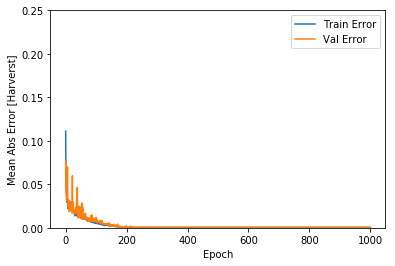

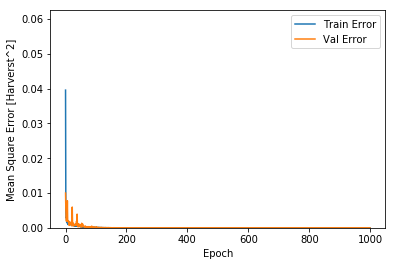

In [36]:
plot_history(history)

In [38]:
scores = model.evaluate(df_test_scale, test_labels)
print("Accuracy: %.2f%%"%(scores[1]*100))

242/242 [==============================] - 0s 45us/step
Accuracy: 0.05%



................................................

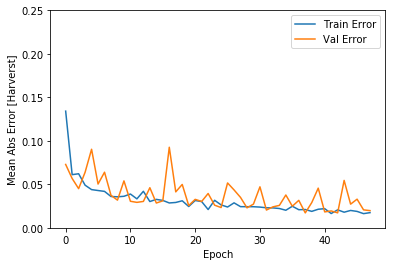

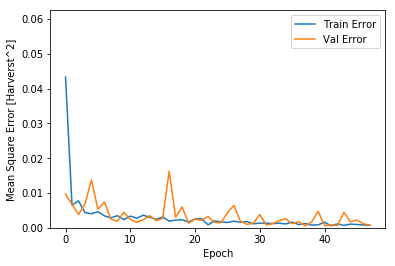

In [39]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(df_train_scale,train_labels, epochs=EPOCHS, validation_split= 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

In [40]:
loss, mae, mse = model.evaluate(df_test_scale, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} Haverst".format(mae))
print("Testing set Mean square Error: {:5.2f} Haverst".format(mse))
print("Testing set loss: {:5.2f} Haverst".format(loss))
scores = model.evaluate(df_test_scale, test_labels)
print("Accuracy: %.2f%%"%(scores[1]*100))

Testing set Mean Abs Error:  0.02 Haverst
Testing set Mean square Error:  0.00 Haverst
Testing set loss:  0.00 Haverst
242/242 [==============================] - 0s 29us/step
Accuracy: 1.82%


### Make Predictions

In [41]:
test_predictions = model.predict(df_test_scale).flatten()
test_predictions.size

242

In [42]:
test_labels.size

242

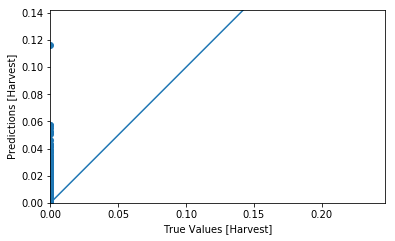

In [43]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Harvest]')
plt.ylabel('Predictions [Harvest]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10,10], [-10,10])

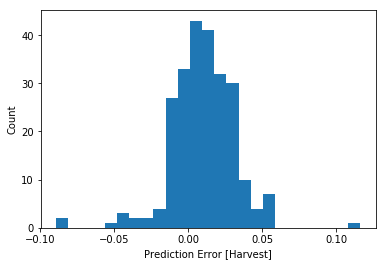

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Harvest]")
_ = plt.ylabel('Count')